In [161]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import keras
import random
from tensorflow.keras import datasets, layers, models

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Creating arrays with images and masks

In [3]:
directory = os.fsencode("../new_maps")

images = []
titulos = []

list_directory = os.listdir(directory.decode("utf-8"))

list_directory.sort()
    
for file in list_directory:
    filename = os.fsdecode(file)
    titulos.append(filename)
    filename_path = directory.decode("utf-8") + "/" + filename
    img = imageio.imread(filename_path)
    images.append(img)
    
directory = os.fsencode("../new_masks")

masks = []
titulos = []

list_directory = os.listdir(directory.decode("utf-8"))

list_directory.sort()
    
for file in list_directory:
    filename = os.fsdecode(file)
    titulos.append(filename)
    filename_path = directory.decode("utf-8") + "/" + filename
    img = imageio.imread(filename_path)
    masks.append(img)
    
masks = np.array(masks)
images = np.array(images)

masks = np.expand_dims(masks, -1)

### Spliting data between train and test

In [4]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2)

### Criating the U-net model

In [5]:
from keras.models import Model, load_model
from keras.layers import Input, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.layers import BatchNormalization

In [6]:
def get_unet(input_img, dropout = 0.1):

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (input_img)
    c1 = BatchNormalization() (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    c1 = BatchNormalization() (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = BatchNormalization() (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    c2 = BatchNormalization() (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = BatchNormalization() (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    c3 = BatchNormalization() (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = BatchNormalization() (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    c4 = BatchNormalization() (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = BatchNormalization() (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    c5 = BatchNormalization() (c5)

    #Expantion path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = BatchNormalization() (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    c6 = BatchNormalization() (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = BatchNormalization() (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    c7 = BatchNormalization() (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = BatchNormalization() (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    c8 = BatchNormalization() (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = BatchNormalization() (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
    c9 = BatchNormalization() (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## For this project we are using a model-based methodology for Image Segmentation

### The metric used to train our model is the Intersection-Over-Union

This metric consists in calculating, for each "class" of the image, the area of overlap between the predicted segmentation and the mask, divided by the union area between the predicted segmentation and the mask. Then the average IOU of the classes is calculated.

source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

In [2]:
from keras import backend as K

##Metrica
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
    return iou

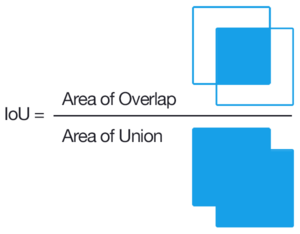

In [3]:
from IPython.display import Image
Image("../images/iou.png")

### Example

(-0.5, 221.5, 217.5, -0.5)

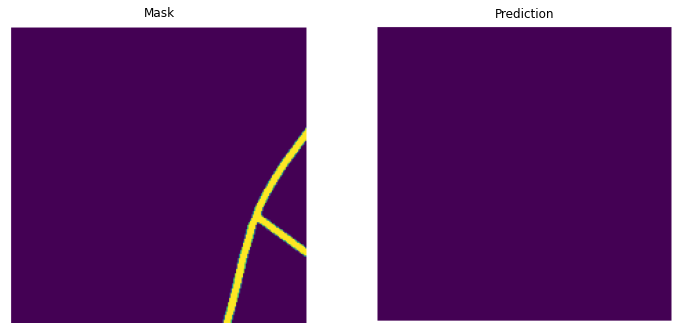

In [217]:
img_A = imageio.imread("iou_pt1.png")
img_B = imageio.imread("iou_pt2.png")

f = plt.figure(figsize=(12,12))
f.add_subplot(1,2,1)
plt.imshow(img_A);
plt.title("Mask")
plt.axis('off')
f.add_subplot(1,2,2)
plt.imshow(img_B);
plt.title("Prediction")
plt.axis('off')

#### Accuracy = ~ 95%
#### IoU:

Roads: Area of Overlap = 0, Area of Union = (5+0)-0 =5
Area of Overlap/Area of Union = 0%

Now for the black background, we do the same thing.
Background: Area of Overlap = 95, Area of Union = (95+100)–95 = 100
Area of Overlap/Area of Union = 95%

#### Mean IoU = (Roads + Background)/2 = (0%+95%)/2 = 47.5%

## Loss Function: Binary Cross Entropy

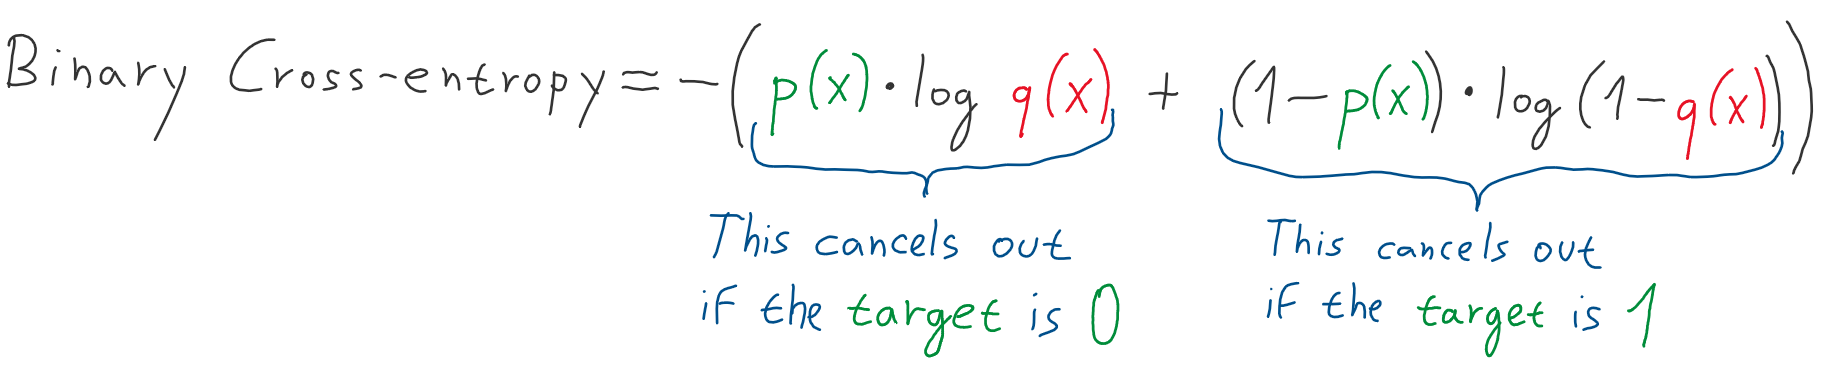

In [4]:
Image("../images/binary_cross_entropy.png")

In [7]:
input_img = Input((256,256,3))
model = get_unet(input_img, dropout=0.05)
model.compile(
        optimizer= Adam(),
        loss= "binary_crossentropy",
        metrics=[iou_coef])
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    batch_size = 16,
                    epochs=60)

Train on 1839 samples, validate on 205 samples
Epoch 1/60
1839/1839 [==============================] - 48s 26ms/step - loss: 0.5171 - iou_coef: 0.0857 - val_loss: 0.4724 - val_iou_coef: 0.0662
Epoch 2/60
1839/1839 [==============================] - 33s 18ms/step - loss: 0.2396 - iou_coef: 0.1488 - val_loss: 0.1854 - val_iou_coef: 0.1842
Epoch 3/60
1839/1839 [==============================] - 33s 18ms/step - loss: 0.1428 - iou_coef: 0.2128 - val_loss: 0.1526 - val_iou_coef: 0.1315
Epoch 4/60
1839/1839 [==============================] - 33s 18ms/step - loss: 0.1089 - iou_coef: 0.2600 - val_loss: 0.0991 - val_iou_coef: 0.3298
Epoch 5/60
1839/1839 [==============================] - 33s 18ms/step - loss: 0.0869 - iou_coef: 0.3164 - val_loss: 0.0870 - val_iou_coef: 0.3081
Epoch 6/60
1839/1839 [==============================] - 33s 18ms/step - loss: 0.0800 - iou_coef: 0.3393 - val_loss: 0.0803 - val_iou_coef: 0.3327
Epoch 7/60
1839/1839 [==============================] - 33s 18ms/step - loss:

In [118]:
model.evaluate(test_images, test_masks)

512/512 [==============================] - 3s 6ms/step


[-208.90835189819336, 3.2108168601989746]

In [119]:
predictions = model.predict(test_images, verbose=1)

512/512 [==============================] - 2s 5ms/step


## Showing Maps // Masks // Predictions

C:\Users\Hiro\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  


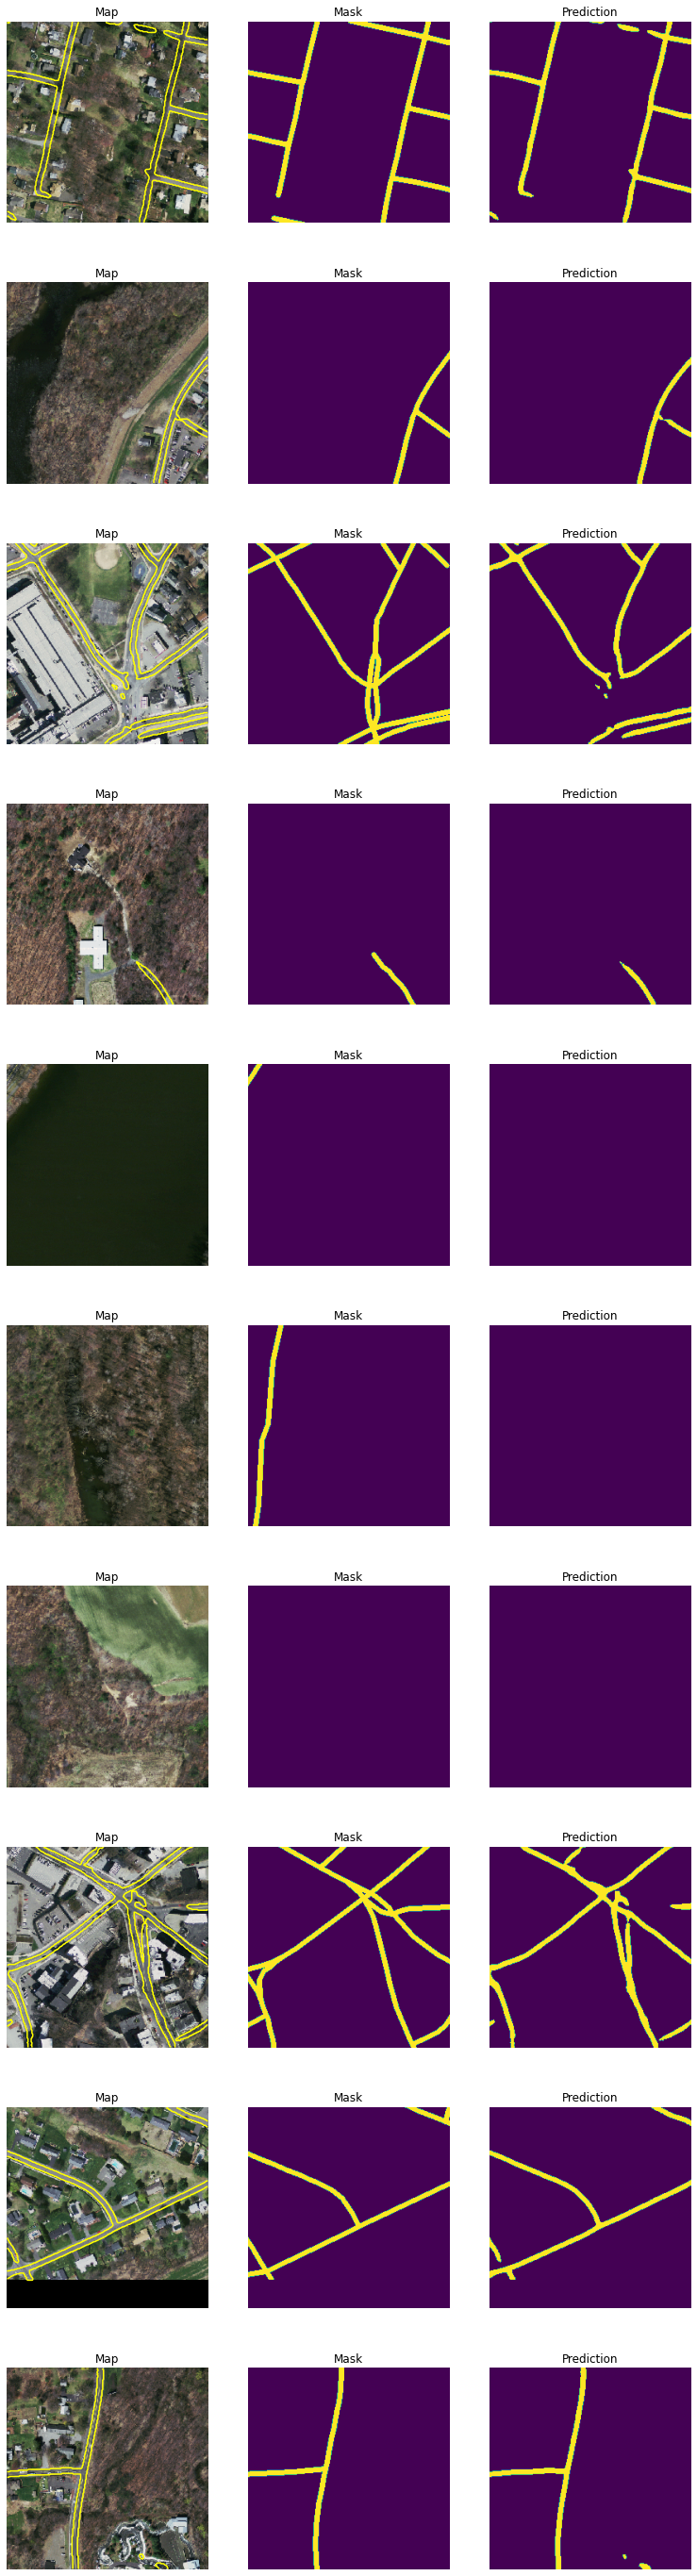

In [160]:
f = plt.figure(figsize=(13,50))
pred = (predictions > 0.5).astype(np.uint8)
j = random.randint(0,50)
for i in range(0,30,3):
    f.add_subplot(10, 3, i+1)
    plt.contour(np.squeeze(pred[j]), colors = 'yellow', levels=[0.5])
    plt.imshow(test_images[j])
    plt.title("Map")
    plt.axis('off')

    f.add_subplot(10, 3, i+2)
    plt.imshow(np.squeeze(test_masks[j]))
    plt.title("Mask")
    plt.axis('off')

    f.add_subplot(10, 3, i+3)
    plt.imshow(np.squeeze(pred[j]))
    plt.title("Prediction")
    plt.axis('off')
    
    j+=1

plt.show()

In [12]:
model.save('my_model.h5') 

## Testing on out training images:

In [108]:
directory = os.fsencode("./new_sanca")

sanca_imgs = []
titulos = []

list_directory = os.listdir(directory.decode("utf-8"))

list_directory.sort()
    
for file in list_directory:
    filename = os.fsdecode(file)
    titulos.append(filename)
    filename_path = directory.decode("utf-8") + "/" + filename
    img = imageio.imread(filename_path)
    sanca_imgs.append(img)

sanca_imgs = np.array(sanca_imgs)

In [109]:
predictions = model.predict(sanca_imgs, verbose=1)

36/36 [==============================] - 0s 6ms/step


## Cropped prediction and  their respective inputs

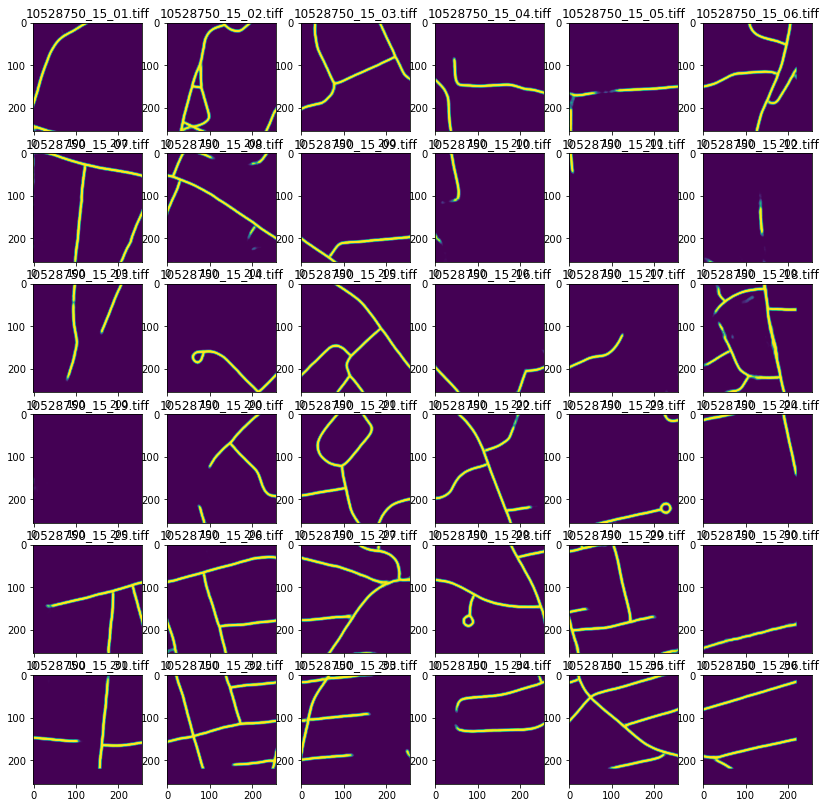

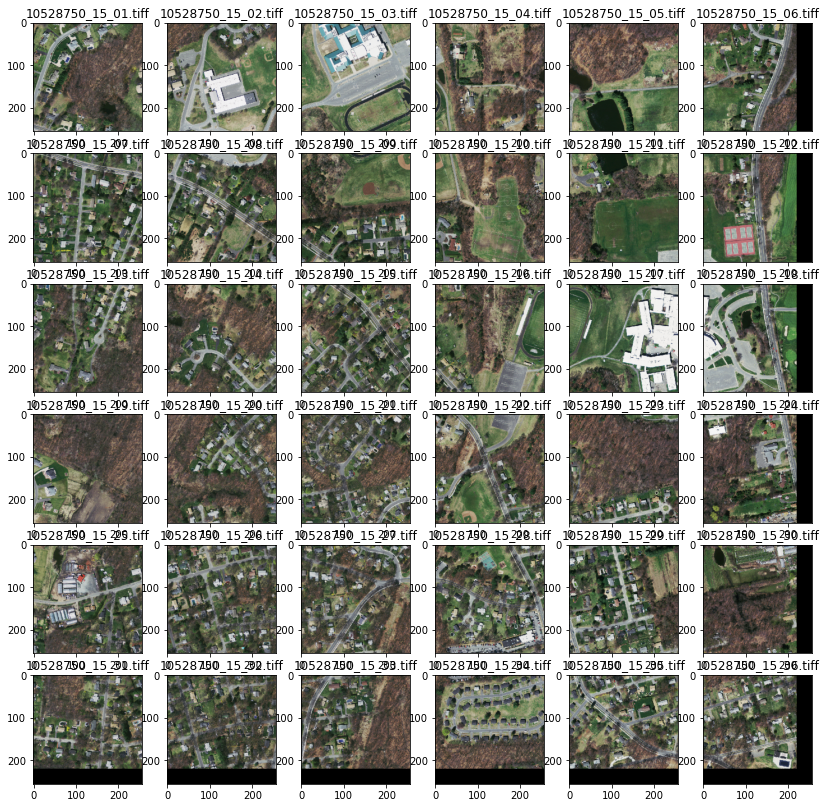

In [111]:
pred = (predictions > 0.5).astype(np.uint8)
plt.figure(figsize=(14,14))
for i in range(0,36):
    plt.subplot(6,6,i+1)
    plt.title(titulos[i])
    plt.imshow(np.squeeze(predictions[i]))
    
directory = os.fsencode("./new_sanca")

masks = []
titulos = []

list_directory = os.listdir(directory.decode("utf-8"))

list_directory.sort()
    
for file in list_directory:
    filename = os.fsdecode(file)
    titulos.append(filename)
    filename_path = directory.decode("utf-8") + "/" + filename
    img = imageio.imread(filename_path)
    masks.append(img)
    
plt.figure(figsize=(14,14))
for i in range(0,36):
    plt.subplot(6,6,i+1)
    plt.title(titulos[i])
    plt.imshow(masks[i])

In [114]:
img_width = img_height = 1536
def rebuild(pred):
    ##Para os mapas
    blank_image = np.zeros((img_height ,img_width,1), dtype = int)
    counter = 0
    for r in range(0,6):
        for c in range(0,6):
            counter += 1
            blank_image[r*256:(r+1)*256, c*256:(c+1)*256] = pred[counter-1]

    blank_image = blank_image[:,:,0]
    plt.figure(figsize=(20,20))
    plt.imshow(np.array(blank_image))
    imageio.imwrite("./sanca/mapa_sanca.tiff", blank_image)

## Rebuilding the cropped prediction

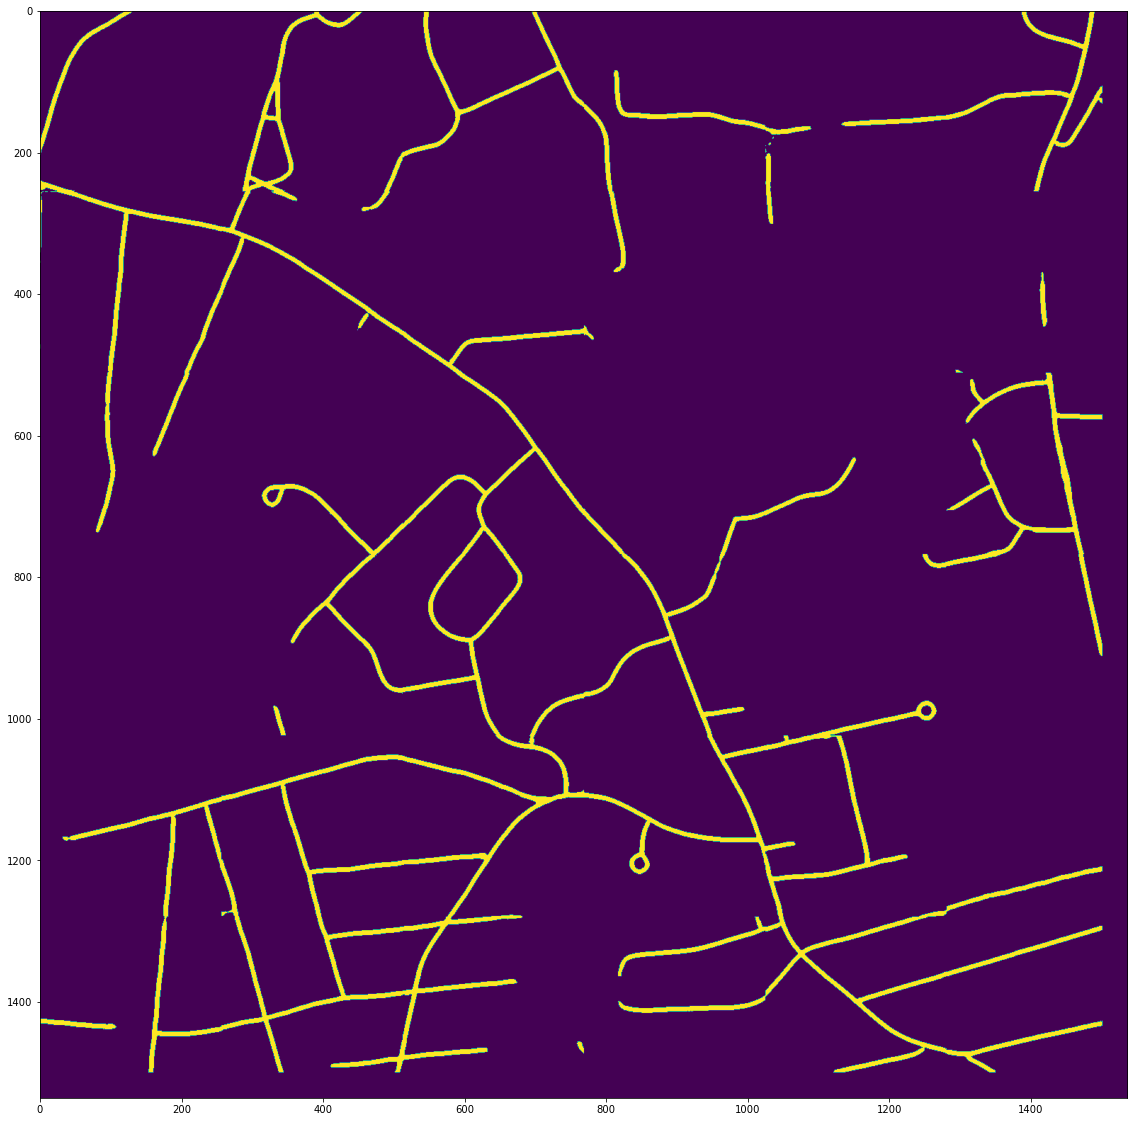

In [115]:
rebuild(pred)

## Final image
#### Overlappig the reconstructed prediction contour over the map input image   

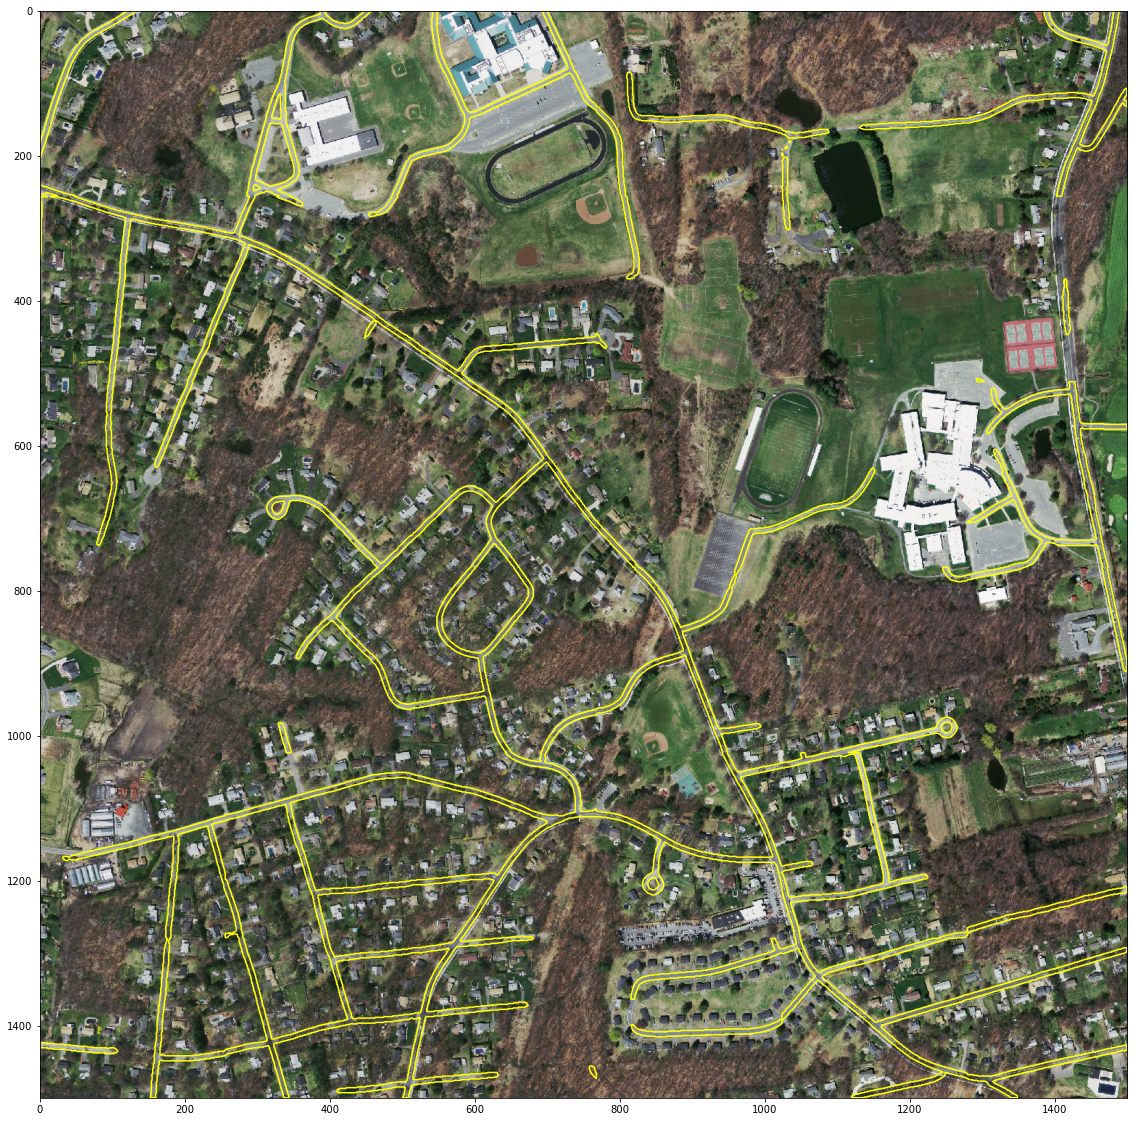

In [155]:
plt.figure(figsize=(20,20))
img = imageio.imread("./sanca/10528750_15.tiff")
contorno = imageio.imread("./sanca/mapa_sanca.tiff")
plt.contour(np.squeeze(contorno), colors = 'yellow', levels=[0.5])
plt.imshow(img)

Load Model:

In [116]:
#model2 = load_model("my_model.h5", custom_objects= {'iou_coef': iou_coef})